# Введение

Структура ноутбука:

1. Импорт библиотек и настройка среды выполнения
2. Загрузка данных о котировках активов
3. Сравнение кумулятивной доходности активов
4. Оптимизация портфеля методом Монте-Карло
5. Оптимизация портфеля алгоритмом SLSQP
6. Бэктестинг оптимизированных портфелей
7. Примечания

# Импорт библиотек и настройка среды выполнения

In [1]:
import os # для работы с файловой системой
import pandas as pd # для создания датафреймов
import numpy as np # для математических преобразований
import datetime as dt # для работы с датами
import matplotlib.pyplot as plt # для посроения графиков
from matplotlib import style # для настройки стиля графиков
import pandas_datareader.data as web # для загрузки данных из веба
from dateutil.relativedelta import relativedelta # для математических вычислений с датами
from scipy.optimize import minimize # для оптимизационной функции

In [2]:
style.use('ggplot') # установка стиля графиков

start = dt.datetime(2019, 1, 1) # самая ранняя дата периода, за который будем загружать информацию
today = dt.datetime.now() # самая поздняя дата периода, за который будем загружать информацию, т.е. сегодня

# Загрузка данных о котировках ценных бумаг

Выбор тикеров для сравнения предоставляется пользователю. Оптимальное количество тикеров для анализа: 5-7. Тикеры российских компаний необходимо указывать с суффиксом ".ME".

In [3]:
tickers = input("Укажите тикеры через пробел. Тикеры российских компаний необходимо указывать с суффиксом .ME (например: YNDX.ME). Оптимальное количество компаний: 5-7.")
tickers = tickers.split(" ")

In [4]:
# Добавим курс доллара к рублю.
tickers.append('USDRUB=X')

# Создадим пустой датафрейм, в котором каждый столбец соответсвует каждому тикеру из списка.
stock_data = pd.DataFrame(columns=tickers)

Для загрузки исторических данных о ценных бумагах будем использовать библиотеку pandas_datareader. Она может использовать различные источники данных, но в данном скрипте будет использоватья Yahoo Finance. Компании, торгуемые на Московской бирже, имеют окончание .ME. Период, за который будут загружаться данные о котировках: с 1 января 2019 года по текущий день. Для анализа будет использоваться скорректированная цена закрытия на конец дня (цена закрытия, скорректированная на дивиденды и сплиты). Точность временных данных в один день недостаточна для алгоритмической торговли, но достаточна для целей данного исследования: фундаментальной балансировки портфеля.

In [5]:
for ticker in tickers:
    stock_data[ticker] = web.DataReader(ticker, 'yahoo', start, today)['Adj Close']

Для тикеров, номинированных в рублях, необходимо сконвертировать стоимость из рублей в доллары. После этого информацию о курсе доллара к рублю можно отбросить.

In [6]:
moex_tickers = [ticker for ticker in tickers if '.ME' in ticker]

# Курс российских акций в долларах = курс акций в рублях / курс доллара к рублю.
for moex_ticker in moex_tickers:
    stock_data[moex_ticker] = stock_data.apply(lambda row: row[moex_ticker] / row['USDRUB=X'], axis=1)

stock_data.drop(columns='USDRUB=X', inplace=True) # удалим курс доллара к рублю
stock_data.columns = stock_data.columns.str.rstrip('.ME') # удалим окончание .ME для российских тикеров 

# Сравнение кумулятивной доходности активов

Нас интересует не сравнение курсов акций в абсолютном выражении и не изучение истории колебаний курсов, а относительный возврат на инвестиции - выраженный как нарастающий итог изменения доходности. Отобразим итог по кумулятивной доходности акций, актуальный по состоянию на сегодня, в графическом и матричном виде. Информацию будем анализировать за годовой период и трехмесячный период.

In [7]:
def compare_returns(returns, period):
# Функция для вывода результатов сравнения доходности активов / портфелей в виде графика и в виде матрицы.

    # отображение возврата на инвестиции в виде графика
    returns.plot()
    plt.title(f"Кумулятивная доходность за последний {period}")
    plt.legend()
    plt.ylabel('Доходность')
    plt.xlabel('Период')
    plt.show()
    
    # отображение возврата на инвестиции в виде матрицы
    returns = returns.tail(1).transpose()
    returns.sort_values(by=returns.columns[0], ascending=False, inplace=True)
    returns = returns.apply(lambda row:"{:.2%}".format(row[0]),  axis=1)
    print(f'Кумулятивная доходность за последний {period}:\n{returns.to_string()}')

In [8]:
def cumulative_return(period, stock_data, show_output):
# Определение функции для вычисления кумулятивного возврата на инвестиции. Функция принимает один аргумент: строкое обозначение временного периода, за который нужно проанализировать возврат на инвестиции.

    # дата отсчета вычисляется в зависимости от переданного функции аргумента 
    if period == "год":
        time_interval = today - relativedelta(years=1)
    elif period == "квартал":
        time_interval = today - relativedelta(months=3)
    else: 
        print("Указан недопустимый период")
        return

    # ограничим набор данных в соответствии с заданным периодом
    last_period_stock_data = stock_data[stock_data.index >= time_interval]
    cumulative_return = (last_period_stock_data.pct_change() + 1).cumprod() - 1
    
    if show_output == True:
        compare_returns(cumulative_return, period)
    else:
        return cumulative_return

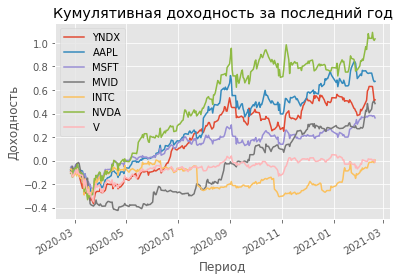

Кумулятивная доходность за последний год:
NVDA    103.37%
AAPL     67.23%
YNDX     51.66%
MVID     48.44%
MSFT     36.30%
INTC      0.48%
V        -1.34%


In [9]:
cumulative_return('год', stock_data, True)

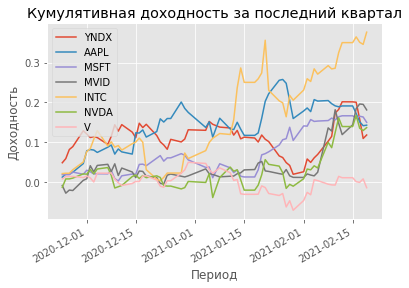

Кумулятивная доходность за последний квартал:
INTC    37.63%
MVID    18.08%
MSFT    14.95%
AAPL    14.24%
NVDA    13.63%
YNDX    11.77%
V       -1.50%


In [10]:
cumulative_return('квартал', stock_data, True)

# Оптимизация портфеля методом Монте-Карло 

В рамках данного исследования оптимальным портфелем будем считать портфель с максимальным коэффициентом Шарпа. Коэффициент Шарпа можно использовать для определения того, насколько хорошо доходность портфеля компенсирует возможные риски по данному портфелю. При прочих равных условиях портфель с более высоким коэффициентом Шарпа будет считаться более сбалансированным. Добиться максимизации коэффициента Шарпа можно подбором оптимальных весов для каждой ценной бумаги в портфеле. 

Коэффициент Шарпа вычисляется по следующей формуле:
$$ \text{Sharpe} = \frac{(R_p - R_f)}{\sigma_p}, $$
где:

$R_{p}$ - ожидаемая доходность портфеля,

$R_{f}$ - доходность безрискового актива (risk-free rate),

$\sigma_{p}$ - стандартное отклонение доходности портфеля.

Ожидамая доходность портфеля вычисляется по следующей формуле:
$$ R_{p} = (w_{1} * r_{1}) + (w_{2} * r_{2}) + ... + (w_{n} * r_{n}) ,$$
где:

$r_{i}$ - доходность актива из портфеля,

$w_{i}$ - вес актива в портфеле.

Стандартное отклонение доходности портфеля вычисляется как:
$$ \sigma_{p} = \sqrt{(w_{i}^2 * \sigma_{i}^2) + (w_{j}^2 * \sigma_{j}^2) + (2 * w_{j} * w_{i} * p_{i,j} * \sigma_{i} * \sigma_{j})} ,$$
где:

$p_{i,j}$ - коэффициент корреляции между доходностью активов в портфеле.  



В качестве ставки доходности безрискового актива примем ставку по годовым долларовым депозитам в Банке Авангард (её можно считать средней по рынку), которая на момент написания скрипта составляла 0,4% годовых.

Для поиска портфеля с оптимальными параметрами будем проводить симуляцию портфелей методом Монте-Карло, создав 10000 портфелей со случайным образом подобранными весами активов. Для каждого портфеля будет вычисляться ожидаемая доходность и волатильность (стандартное отклонение).

In [11]:
# Зададим параметры испытаний Монте-Карло.
number_of_tickers = len(stock_data.columns)
risk_free_rate = 0.004 
number_of_portfolios = 10000

# Для математического прогнозирования доходности необходимо проводить усреднение доходности. Для корректного вычисления усредненной во времени доходности необходимо работать с логарифмом доходности.
log_returns = np.log(stock_data/stock_data.shift(1))

In [12]:
# Создадим массивы, заполненные нулями, для хранения значений весов, доходностей и волатильности активов, а также коэффициентов Шарпа.
weights_array = np.zeros((number_of_portfolios, number_of_tickers))
returns_array = np.zeros(number_of_portfolios)
volatilities_array = np.zeros(number_of_portfolios)
sharpe_ratios_array = np.zeros(number_of_portfolios)

# Проведение симуляции.
for portfolio in range(number_of_portfolios):

    # Генерируются случайные веса. Сумма весов не должна превышать 1. Далее веса добавляются в массив весов.
    weights = np.array(np.random.random(number_of_tickers))
    weights = weights / np.sum(weights)
    weights_array[portfolio, :] = weights

    # Вычисление ожидаемой доходности. Ожидаемую логарифмированную доходность необходимо аннуализировать, т.е. привести к среднегодовому значению с учетом количества торговых дней в году (252).
    returns_array[portfolio] = np.sum((log_returns.mean() * weights) * 252)

    # Вычисление волатильности.
    volatilities_array[portfolio] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

    # Вычисление коэффициентов Шарпа.
    sharpe_ratios_array[portfolio] = (returns_array[portfolio] - risk_free_rate) / volatilities_array[portfolio]

# Сведение массивов в единый массив.
simulations_data = [returns_array, volatilities_array, sharpe_ratios_array, weights_array]

# Создание датафрейма из единого массива и приведение его в привычный вид.
simulations_df = pd.DataFrame(data=simulations_data).T
simulations_df.columns = [
    'Доходность',
    'Волатильность',
    'Коэффициент Шарпа',
    'Веса активов'
]

simulations_df = simulations_df.infer_objects() # для корректного определения типа данных

# Выведем веса активов в отдельные столбцы.
simulations_df[list(stock_data.columns)] = pd.DataFrame(simulations_df['Веса активов'].to_list(), columns=[list(stock_data.columns)])
simulations_df.drop(columns='Веса активов', inplace = True)

In [13]:
# Найдем портфель с максимальным коэффициентом Шарпа.
max_sharpe_ratio = simulations_df.iloc[simulations_df['Коэффициент Шарпа'].argmax()]
monte_carlo_max_sharpe_ratio_wheights = max_sharpe_ratio.drop(labels=['Доходность', 'Волатильность', 'Коэффициент Шарпа'])
print(f"Результат портфеля c наибольшим коэффициентом Шарпа:\n\n{max_sharpe_ratio[['Доходность', 'Волатильность', 'Коэффициент Шарпа']].to_string()}")
print(f"\nСтруктура портфеля:\n{max_sharpe_ratio.drop(labels=['Доходность', 'Волатильность', 'Коэффициент Шарпа']).to_string()}")

Результат портфеля c наибольшим коэффициентом Шарпа:

Доходность           0.597404
Волатильность        0.281905
Коэффициент Шарпа    2.104981

Структура портфеля:
YNDX    0.170866
AAPL    0.412421
MSFT    0.053277
MVID    0.178879
INTC    0.010175
NVDA    0.152104
V       0.022278


In [14]:
# Найдем портфель с наибольшей доходностью.
max_returns = simulations_df.iloc[simulations_df['Доходность'].argmax()]
print(f"Результат портфеля c наибольшей доходностью:\n\n{max_returns[['Доходность', 'Волатильность', 'Коэффициент Шарпа']].to_string()}")
print(f"\nСтруктура портфеля:\n{max_returns.drop(labels=['Доходность', 'Волатильность', 'Коэффициент Шарпа']).to_string()}")

Результат портфеля c наибольшей доходностью:

Доходность           0.668446
Волатильность        0.350883
Коэффициент Шарпа    1.893640

Структура портфеля:
YNDX    0.069422
AAPL    0.263162
MSFT    0.189440
MVID    0.057132
INTC    0.016386
NVDA    0.404334
V       0.000125


In [15]:
# Найдем портфель с наименьшей волатильностью.
min_volatility = simulations_df.iloc[simulations_df['Волатильность'].argmin()]
print(f"Результат портфеля c наименьшей волатильностью:\n\n{min_volatility[['Доходность', 'Волатильность', 'Коэффициент Шарпа']].to_string()}")
print(f"\nСтруктура портфеля:\n{min_volatility.drop(labels=['Доходность', 'Волатильность', 'Коэффициент Шарпа']).to_string()}")

Результат портфеля c наименьшей волатильностью:

Доходность           0.427052
Волатильность        0.242573
Коэффициент Шарпа    1.744019

Структура портфеля:
YNDX    0.172158
AAPL    0.026538
MSFT    0.304289
MVID    0.302790
INTC    0.083017
NVDA    0.014857
V       0.096351


Теперь построим диаграмму рассеяния, отражающую взаимосвязь между ожидаемой доходностью, волотильностью и коэффициентом Шарпа.

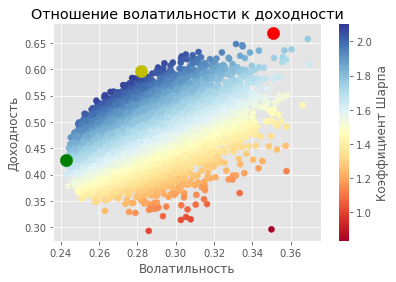

In [16]:
plt.scatter(
    y=simulations_df['Доходность'],
    x=simulations_df['Волатильность'],
    c=simulations_df['Коэффициент Шарпа'],
    cmap='RdYlBu'
)

plt.title('Отношение волатильности к доходности')
plt.colorbar(label='Коэффициент Шарпа')
plt.xlabel('Волатильность')
plt.ylabel('Доходность')

# Максимальному коэффициенту Шарпа будет соответствовать желтая точка.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=".",
    color='y',
    s=600
)

# Миминимальной волатильности будет соответствовать зеленая точка.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=".",
    color='g',
    s=600
)

# Максимальной доходности будет соответствовать красная точка.
plt.scatter(
    max_returns[1],
    max_returns[0],
    marker=".",
    color='r',
    s=600
)

plt.show()

# Оптимизация портфеля алгоритмом SLSQP

Теперь для поиска наибольшего коэффициента Шарпа, наибольшей доходности и наименьшей волатильности применим алгоритм SLSQP (Sequential Least SQuares Programming), реализованный в минимизационной функции библиотеки SciPy.

Особенностью принименения данного метода является, то, что оптимизировать мы будем отрицательный коэффициент Шарпа. Необходимость вычисления отрицательного коэффициента Шарпа обусловлена тем, что в библиотеке SciPy в рамках данной задачи необходимо применять минимизационную функцию - таким образом, для получения наибольшего коэффициента Шарпа необходимо минимизировать отрицательный коэффициент Шарпа. Для минимизационной функции необходимо также задать следующие ограничения:
* сумма весов активов портфеля должна равняться единице,
* вес каждого актива должен быть в диапазоне от 0 до 1,
* начальные весы устанавливаются одинаковыми для всех активов.  

In [17]:
# Вычисление максимального коэффициента Шарпа.
def negative_sharpe(weights, mean_returns, covariance, risk_free_rate):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

def minimize_negative_sharpe(mean_returns, covariance, risk_free_rate):
    args = (mean_returns, covariance, risk_free_rate)
    bound = (0.0,1.0)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple(bound for ticker in range(number_of_tickers))
    initial_guess = number_of_tickers*[1./number_of_tickers,]
    result = minimize(negative_sharpe, initial_guess, args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

max_sharpe_portfolio = minimize_negative_sharpe(log_returns.mean(), log_returns.cov(), risk_free_rate)

max_sharpe_ratio = negative_sharpe(max_sharpe_portfolio.x, log_returns.mean(), log_returns.cov(), risk_free_rate) * (-1)
max_sharpe_portfolio_returns = np.sum(log_returns.mean() * max_sharpe_portfolio.x) * 252
max_sharpe_portfolio_volatility = np.sqrt(np.dot(max_sharpe_portfolio.x.T, np.dot(log_returns.cov(), max_sharpe_portfolio.x))) * np.sqrt(252)
print(f'Портфель с наибольшим коэффициентом Шарпа\n\nКоэффициент Шарпа: {round(max_sharpe_ratio,2)}\nДоходность: {round(max_sharpe_portfolio_returns,2)}\nВолатильность: {round(max_sharpe_portfolio_volatility,2)}')

max_sharpe_ratio_results = pd.DataFrame([round(x,2) for x in max_sharpe_portfolio['x']],index=list(stock_data.columns)).T
max_sharpe_ratio_results.index=[''] * len(max_sharpe_ratio_results)
print(f'\nСтруктура портфеля:{max_sharpe_ratio_results.T}')

Портфель с наибольшим коэффициентом Шарпа

Коэффициент Шарпа: 2.16
Доходность: 0.61
Волатильность: 0.28

Структура портфеля:          
YNDX  0.15
AAPL  0.44
MSFT  0.00
MVID  0.26
INTC  0.00
NVDA  0.16
V     0.00


In [18]:
# Аналогично вычислим портфель с наибольшей доходностью.
def portfolio_return(weights, mean_returns):
    portfolio_return = np.sum(mean_returns * weights) * 252
    return -portfolio_return

def max_return(mean_returns):
    args = (mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for ticker in range(number_of_tickers))
    initial_guess = number_of_tickers*[1./number_of_tickers,]
    result = minimize(portfolio_return, initial_guess, args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
    
max_return_portfolio = max_return(log_returns.mean())

max_return_sharpe_ratio = negative_sharpe(max_return_portfolio.x, log_returns.mean(), log_returns.cov(), risk_free_rate) * (-1)
max_return_portfolio_returns = np.sum(log_returns.mean() * max_return_portfolio.x) * 252
max_return_portfolio_volatility = np.sqrt(np.dot(max_return_portfolio.x.T, np.dot(log_returns.cov(), max_return_portfolio.x))) * np.sqrt(252)
print(f'Портфель с наибольшей доходностью\n\nКоэффициент Шарпа: {round(max_return_sharpe_ratio,2)}\nДоходность: {round(max_return_portfolio_returns,2)}\nВолатильность: {round(max_return_portfolio_volatility,2)}')

max_return_results = pd.DataFrame([round(x,2) for x in max_return_portfolio['x']],index=list(stock_data.columns)).T
max_return_results.index=[''] * len(max_return_results)
print(f'\nСтруктура портфеля:{max_return_results.T}')

Портфель с наибольшей доходностью

Коэффициент Шарпа: 1.64
Доходность: 0.83
Волатильность: 0.5

Структура портфеля:         
YNDX  0.0
AAPL  0.0
MSFT  0.0
MVID  0.0
INTC  0.0
NVDA  1.0
V     0.0


In [19]:
# Аналогично вычислим портфель с наименьшей волатильностью.
def portfolio_volatility(weights, mean_returns, covariance):
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)
    return portfolio_volatility

def min_volatility(mean_returns, covariance):
    args = (mean_returns, covariance)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for ticker in range(number_of_tickers))
    initial_guess = number_of_tickers*[1./number_of_tickers,]
    result = minimize(portfolio_volatility, initial_guess, args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
    
min_volatility_portfolio = min_volatility(log_returns.mean(), log_returns.cov())

min_volatility_sharpe_ratio = negative_sharpe(min_volatility_portfolio.x, log_returns.mean(), log_returns.cov(), risk_free_rate) * (-1)
min_volatility_portfolio_returns = np.sum(log_returns.mean() * min_volatility_portfolio.x) * 252
min_volatility_portfolio_volatility = np.sqrt(np.dot(min_volatility_portfolio.x.T, np.dot(log_returns.cov(), min_volatility_portfolio.x))) * np.sqrt(252)
print(f'Портфель с наименьшей волатильностью\n\nКоэффициент Шарпа: {round(min_volatility_sharpe_ratio,2)}\nДоходность: {round(min_volatility_portfolio_returns,2)}\nВолатильность: {round(min_volatility_portfolio_volatility,2)}')

min_volatility_results = pd.DataFrame([round(x,2) for x in min_volatility_portfolio['x']],index=list(stock_data.columns)).T
min_volatility_results.index=[''] * len(min_volatility_results)
print(f'\nСтруктура портфеля:{min_volatility_results.T}')

Портфель с наименьшей волатильностью

Коэффициент Шарпа: 1.71
Доходность: 0.42
Волатильность: 0.24

Структура портфеля:          
YNDX  0.16
AAPL  0.02
MSFT  0.31
MVID  0.31
INTC  0.06
NVDA  0.00
V     0.14


# Бэктестинг оптимальных портфелей

Для анализа эффективности оптимальных портфелей проведем тестирование на исторических данных и сравним их результативность с результативностью индексов широкого рынка и фондов. В качестве бенчмарка будем использовать следующие индексы и активы:
* Индекс S&P 500
* Индекс Nasdaq Composite
* Индекс МосБиржи
* iShares Gold Trust ETF

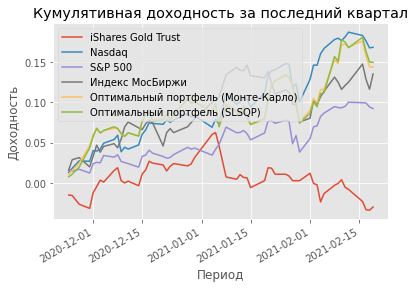

Кумулятивная доходность за последний квартал:
Nasdaq                                16.78%
Оптимальный портфель (SLSQP)          14.91%
Оптимальный портфель (Монте-Карло)    14.34%
Индекс МосБиржи                       13.48%
S&P 500                                9.20%
iShares Gold Trust                    -2.97%


In [20]:
monte_carlo_max_sharpe_ratio_return = pd.DataFrame(cumulative_return("квартал", stock_data, False).dot(monte_carlo_max_sharpe_ratio_wheights), columns=['Оптимальный портфель (Монте-Карло)'])
SLSQP_max_sharpe_ratio_return = pd.DataFrame(cumulative_return("квартал", stock_data, False).dot(max_sharpe_ratio_results.iloc[0]), columns=['Оптимальный портфель (SLSQP)'])

monte_carlo_max_sharpe_ratio_return.name = "Монте-Карло"
SLSQP_max_sharpe_ratio_return.name = "SLSQP"

tickers_to_compare = ['IAU', '^IXIC', '^GSPC', 'IMOEX.ME']
stock_data_to_compare = pd.DataFrame(columns=tickers_to_compare)

for ticker in tickers_to_compare:
    stock_data_to_compare[ticker] = web.DataReader(ticker, 'yahoo', start, today)['Close']

stock_data_to_compare.rename(columns={'^GSPC': 'S&P 500', '^IXIC': 'Nasdaq', 'IAU': 'iShares Gold Trust', 'IMOEX.ME': 'Индекс МосБиржи'}, inplace=True)

stock_data_to_compare_return = cumulative_return("квартал", stock_data_to_compare, False)
stock_data_to_compare_return = stock_data_to_compare_return.merge(monte_carlo_max_sharpe_ratio_return, how='inner', on="Date")
stock_data_to_compare_return = stock_data_to_compare_return.merge(SLSQP_max_sharpe_ratio_return, how='inner', on="Date")
compare_returns(stock_data_to_compare_return, "квартал")

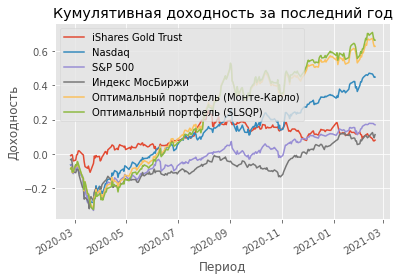

Кумулятивная доходность за последний год:
Оптимальный портфель (SLSQP)          66.46%
Оптимальный портфель (Монте-Карло)    62.85%
Nasdaq                                44.88%
S&P 500                               17.05%
Индекс МосБиржи                       11.32%
iShares Gold Trust                     8.08%


In [21]:
monte_carlo_max_sharpe_ratio_return = pd.DataFrame(cumulative_return("год", stock_data, False).dot(monte_carlo_max_sharpe_ratio_wheights), columns=['Оптимальный портфель (Монте-Карло)'])
SLSQP_max_sharpe_ratio_return = pd.DataFrame(cumulative_return("год", stock_data, False).dot(max_sharpe_ratio_results.iloc[0]), columns=['Оптимальный портфель (SLSQP)'])

monte_carlo_max_sharpe_ratio_return.name = "Монте-Карло"
SLSQP_max_sharpe_ratio_return.name = "SLSQP"

tickers_to_compare = ['IAU', '^IXIC', '^GSPC', 'IMOEX.ME']
stock_data_to_compare = pd.DataFrame(columns=tickers_to_compare)

for ticker in tickers_to_compare:
    stock_data_to_compare[ticker] = web.DataReader(ticker, 'yahoo', start, today)['Close']

stock_data_to_compare.rename(columns={'^GSPC': 'S&P 500', '^IXIC': 'Nasdaq', 'IAU': 'iShares Gold Trust', 'IMOEX.ME': 'Индекс МосБиржи'}, inplace=True)

stock_data_to_compare_return = cumulative_return("год", stock_data_to_compare, False)
stock_data_to_compare_return = stock_data_to_compare_return.merge(monte_carlo_max_sharpe_ratio_return, how='inner', on="Date")
stock_data_to_compare_return = stock_data_to_compare_return.merge(SLSQP_max_sharpe_ratio_return, how='inner', on="Date")
compare_returns(stock_data_to_compare_return, "год")

# Примечания

* Историческая доходность не гарантирует будущей доходности.
* Ни комментарии к скрипту, ни результаты работы скрипта не являются индивидуальной инвестиционной рекомендацией. Каждый инвестор должен подбирать себе портфель в соответствии с собственными стратегическим видением, аппетиту к доходности и толерантности к риску.